# Charuco pose estimation with openpose calibrated camera set

We are using the openpose calibration of a camera and use the intrinsics and distortion coeffiencent to estimate the pose of a charuco board.

In [3]:
import glob
import numpy as np
import cv2
from cv2 import aruco

import os

import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

squareLength = 138.0 / 1000 # chessboard square side length (normally in meters)
markerLength = 87.0 / 1000 # marker side length (same unit than squareLength)
squaresX = 5
squaresY = 7

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard_create(squaresX,squaresY,squareLength,markerLength,dictionary)

#%matplotlib notebook

print("opencv version",cv2.__version__)

opencv version 3.4.1


# Load Calibration

In [4]:
filename = "models/18284509.xml"

fs = cv2.FileStorage(filename, cv2.FILE_STORAGE_READ)

intrinsics = fs.getNode("Intrinsics").mat()
dist_coeffs = fs.getNode("Distortion").mat()

fs.release()

print(intrinsics)
print(dist_coeffs)

[[1.60620154e+03 0.00000000e+00 6.33329895e+02]
 [0.00000000e+00 1.60141589e+03 5.17156372e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.38691339]
 [ 0.18264715]
 [ 0.00050779]
 [ 0.00070454]]


## Load Images 

In [7]:
images = glob.glob("aruco_origin__138_87/cam_18284509_*.jpg")
images.sort()

print("{} image files found".format(len(images))) 


2 image files found


image shape: (1024, 1280, 3)


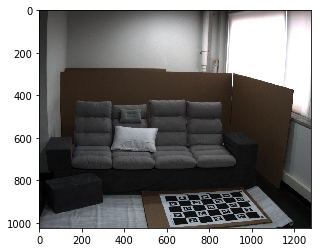

In [8]:
i = 0
figure1 = plt.figure()
img = cv2.imread(images[i])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),  interpolation = "nearest")
print("image shape: {}".format(img.shape))

imsize = (img.shape[0], img.shape[1])


# check undistorted image

(-0.5, 1279.5, 1023.5, -0.5)

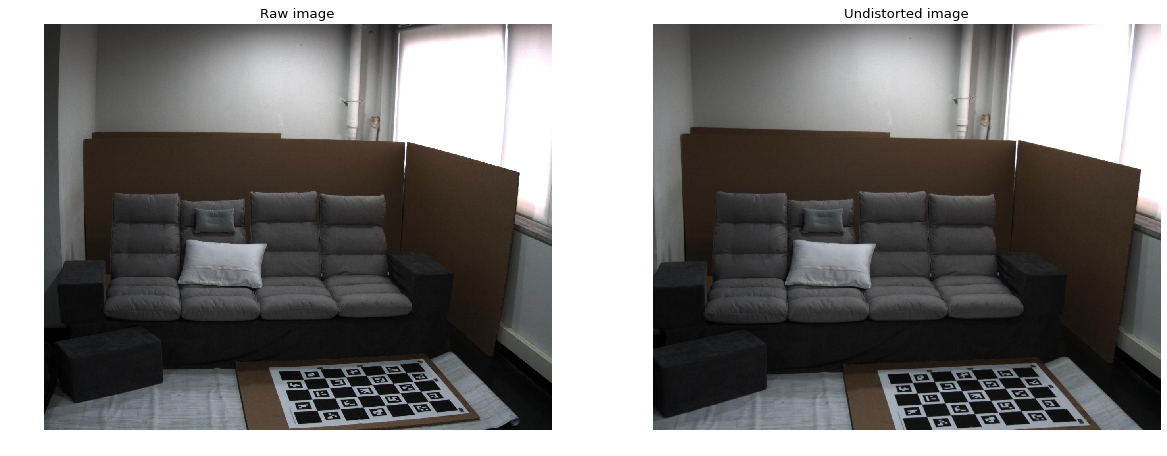

In [9]:
i = 0
plt.figure(figsize=(18, 10), dpi= 80)
img = cv2.imread(images[i])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undist = cv2.undistort(img,intrinsics,dist_coeffs,None)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Undistorted image")
plt.axis("off")

In [12]:

params =  aruco.DetectorParameters_create()
print("param", params)
print("detector params:")
for val in dir(params):
    if not val.startswith("__"):
        print("\t{} : {}".format(val, params.__getattribute__(val)))
params.adaptiveThreshWinSizeStep = 2




# function because we use later
def find_charuco_board(img, board, dictionary):
    corner_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, dictionary, parameters=params)    
    if len(corners)>0:
        for corner in corners:
            cv2.cornerSubPix(gray, corner, winSize=(3,3), zeroZone=(-1,-1), criteria=corner_criteria)        
        ret, detectedCorners, detectedIds = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
        if detectedCorners is not None and detectedIds is not None and len(detectedCorners)>3:
            return detectedCorners, detectedIds
    return [], []

corners, ids = find_charuco_board(img, board, dictionary)


            

param <aruco_DetectorParameters 0x118ca73d0>
detector params:
	adaptiveThreshConstant : 7.0
	adaptiveThreshWinSizeMax : 23
	adaptiveThreshWinSizeMin : 3
	adaptiveThreshWinSizeStep : 10
	cornerRefinementMaxIterations : 30
	cornerRefinementMethod : 0
	cornerRefinementMinAccuracy : 0.1
	cornerRefinementWinSize : 5
	create : <built-in method create of type object at 0x10babc1b0>
	errorCorrectionRate : 0.6
	markerBorderBits : 1
	maxErroneousBitsInBorderRate : 0.35
	maxMarkerPerimeterRate : 4.0
	minCornerDistanceRate : 0.05
	minDistanceToBorder : 3
	minMarkerDistanceRate : 0.05
	minMarkerPerimeterRate : 0.03
	minOtsuStdDev : 5.0
	perspectiveRemoveIgnoredMarginPerCell : 0.13
	perspectiveRemovePixelPerCell : 4
	polygonalApproxAccuracyRate : 0.03


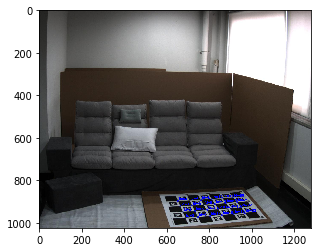

In [14]:
# draw a corner

figure1 = plt.figure()
img2 = cv2.aruco.drawDetectedCornersCharuco(img, corners, ids)

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),  interpolation = "nearest")
plt.show()




## check calibration result

Draw Coordinate axis

In [17]:
def find_aruco_markers(img, dictionary):
    corner_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, dictionary)    
    if len(corners)>0:
        for corner in corners:
            cv2.cornerSubPix(gray, corner, winSize=(3,3), zeroZone=(-1,-1), criteria=corner_criteria)        
        
        return corners, ids
    return [], []

position (tvec) [[-0.10802398]
 [ 0.9228511 ]
 [ 4.04822832]] 
length 4.153489598459625
rotation matrix 3x3 from rvec) {}  [[ 0.17660103  0.98361793  0.03616405]
 [ 0.22600086 -0.00476204 -0.97411546]
 [-0.95798522  0.1802029  -0.22313948]]
trans [-0.10802397708534184, 0.9228510964937437, 4.048228318485416]


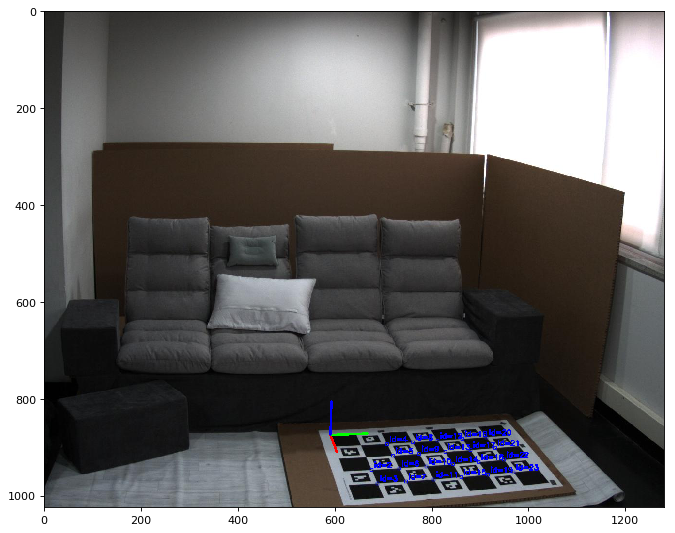

In [36]:
img = cv2.imread(images[0])

corners, ids = find_charuco_board(img, board, dictionary)

img2 = cv2.aruco.drawDetectedCornersCharuco(img, corners, ids)
valid, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(corners, ids, board, intrinsics, dist_coeffs)

print("position (tvec) {} ".format(tvec))

print("length {}".format(np.linalg.norm(tvec)))

# calculate the rotation matrix from the rvec    
rot3x3, _ = cv2.Rodrigues(rvec)
print("rotation matrix 3x3 from rvec) {} ",format(rot3x3))

trans = [tvec[0][0], tvec[1][0], tvec[2][0]]
print("trans",trans)

a = {}
a["rot3x3"] = rot3x3.tolist()

cv2.aruco.drawAxis(img2, intrinsics, dist_coeffs, rvec, tvec, 0.2) 

plt.figure(figsize=(10, 10), dpi= 80)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),  interpolation = "nearest")




In [ ]:
# calculate the inverse matrix

In [58]:
#https://github.com/elliotwoods/Rulr-2.0/blob/master/rulr/Math/_Essentials.py
def make_identity_matrix():
    return np.eye(4, 4, dtype=np.float32)

#https://github.com/elliotwoods/ofxCvMin/blob/master/src/ofxCvMin/Helpers.cpp#L10
def make_rigid_body_transform_matrix(rotation, translation_vector, inverse = False):
    if rotation.shape == (3, 3):
        rot3x3 = rotation
    else:
        rot3x3, _ = cv2.Rodrigues(rotation)

    matrix = make_identity_matrix()

    matrix[0:3, 0:3] = rot3x3
    matrix[0:3, 3] = translation_vector.transpose()

    if inverse:
        matrix = np.linalg.inv(matrix)
    return matrix






In [55]:
rotM = cv2.Rodrigues(rvec)[0]
cameraPosition = -np.matrix(rotM).T * np.matrix(tvec)

print(cameraPosition)


[[ 3.68865491]
 [-0.6188535 ]
 [ 1.80618968]]


In [62]:
m = make_rigid_body_transform_matrix(rot3x3, tvec, False)
t4 = [0,0,0,1]
print(m.dot(t4))



[-0.10802398  0.92285109  4.04822826  1.        ]
